In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from pylab import rcParams
import warnings

warnings.filterwarnings('ignore')

In [53]:
data_november = pd.read_excel('/content/sales_november.xlsx')
data_desember = pd.read_excel('/content/sales_desember_2022.xlsx')
data_januari = pd.read_excel('/content/sales_januari.xlsx')
data_februari = pd.read_excel('/content/sales_februari.xlsx')
data_maret = pd.read_excel('/content/sales_maret.xlsx')
data_april = pd.read_excel('/content/sales_april.xlsx')


df = [data_november, data_desember, data_januari, data_februari, data_maret, data_april]
df = pd.concat(df)


In [54]:
df = df[['HARI DAN TANGGAL', 'Product Name', 'Variation', 'Quantity', 'SKU Unit Original Price', 'Order Amount']]
df.rename(columns=lambda x: x.replace(" ", "_").lower() if x != 'HARI DAN TANGGAL' else 'Date', inplace=True)

In [55]:
df = df.dropna()
df.isnull().sum()

Date                       0
product_name               0
variation                  0
quantity                   0
sku_unit_original_price    0
order_amount               0
dtype: int64

In [56]:
import pandas as pd

# Assuming your DataFrame has a 'Date' column
df['Date'] = pd.to_datetime(df['Date'])  # Convert 'Date' column to datetime type

# Filter the DataFrame based on a specific year
desired_year = 1970  # Replace with your desired year
filtered_df = df[df['Date'].dt.year == desired_year]

# Display the filtered DataFrame
print(filtered_df)


Empty DataFrame
Columns: [Date, product_name, variation, quantity, sku_unit_original_price, order_amount]
Index: []


In [57]:
def clean_numeric_column(df, column):

    df[column] = df[column].str.replace(r'IDR|\.', '', regex=True)
    df[column] = pd.to_numeric(df[column])
    return df

df = clean_numeric_column(df, 'sku_unit_original_price')
df = clean_numeric_column(df, 'order_amount')

In [58]:
total_unit = []
for product in df['product_name']:
        if product == 'OWELA Eve Rosse Eau De Parfume - 3 PCS':
            total_unit.append(3.0)
        elif product == 'OWELA Eve Rosse Eau De Parfume - 5 PCS':
            total_unit.append(5.0)
        else:
            total_unit.append(1.0)
df['total_unit'] = total_unit

In [59]:
df['variation'].unique()

array(['BELI 1', 'BELI 2', 'BELI 3 PCS', 'BELI 1 GRATIS 1', 'BELI 5 PCS'],
      dtype=object)

In [60]:
def clean_variation(df, column):
    df[column] = df[column].str.replace('BELI 1 GRATIS 1', '2').str.replace(r'BELI|PCS|\s', '', regex=True).astype(float)
    return df

df = clean_variation(df, 'variation')
df.variation.unique()

array([1., 2., 3., 5.])

In [61]:
df['sold_items'] = df['variation'] * df['quantity'] * df['total_unit']


In [62]:
df = df.groupby(df.Date.dt.date)["sold_items"].sum().reset_index()
df = df.set_index('Date')
df.shape



(118, 1)

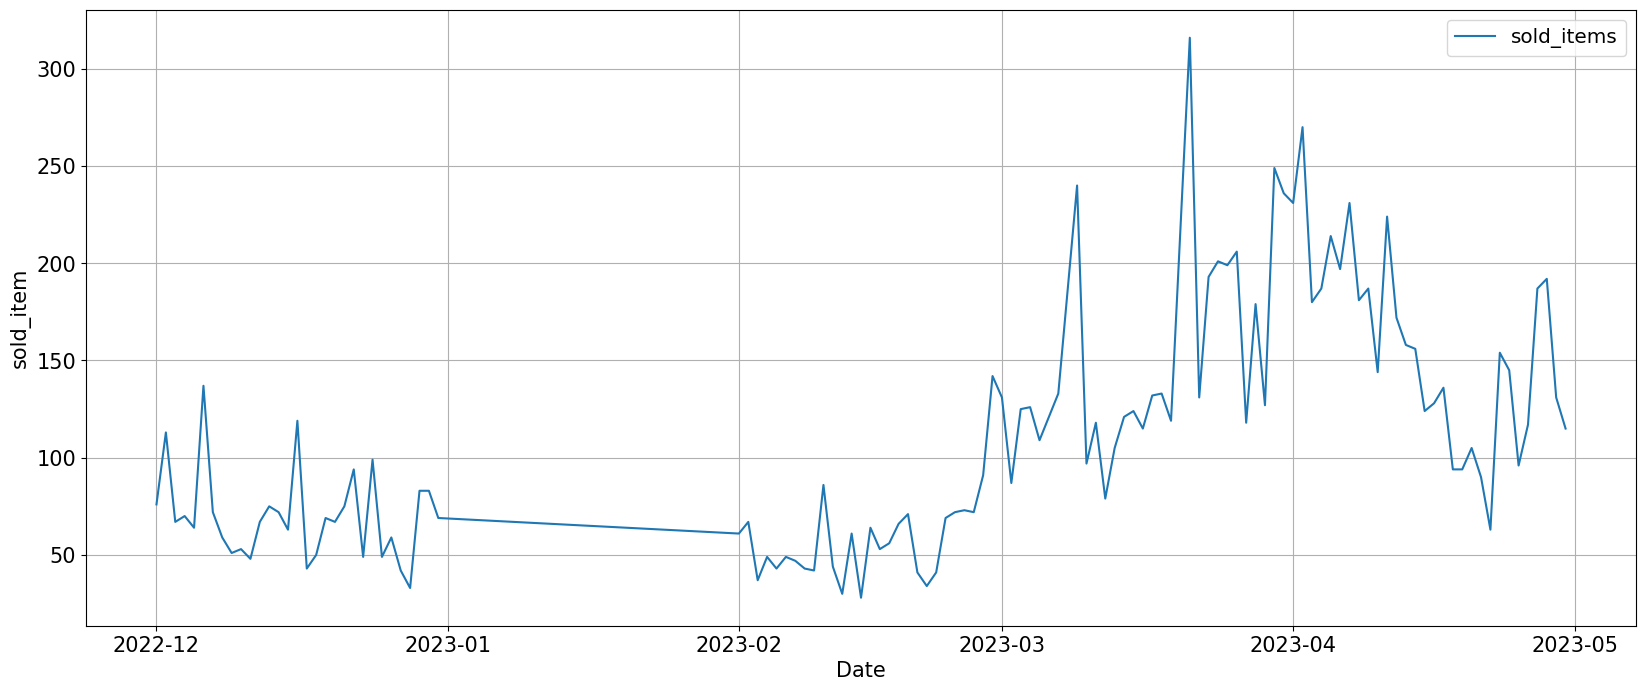

In [63]:
#Plotting the time-series
df.plot(figsize=(20,8))
plt.grid();
plt.xlabel('Date',fontsize=15)
plt.ylabel('sold_item',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")
plt.show()

In [64]:
df.head(2)

,sold_items
Date,
2022-12-01,76.0
2022-12-02,113.0


In [65]:
df.shape

(118, 1)

In [66]:
df.tail()

,sold_items
Date,
2023-04-26,117.0
2023-04-27,187.0
2023-04-28,192.0
2023-04-29,131.0
2023-04-30,115.0


In [67]:
train, test = df[:77], df[77:]

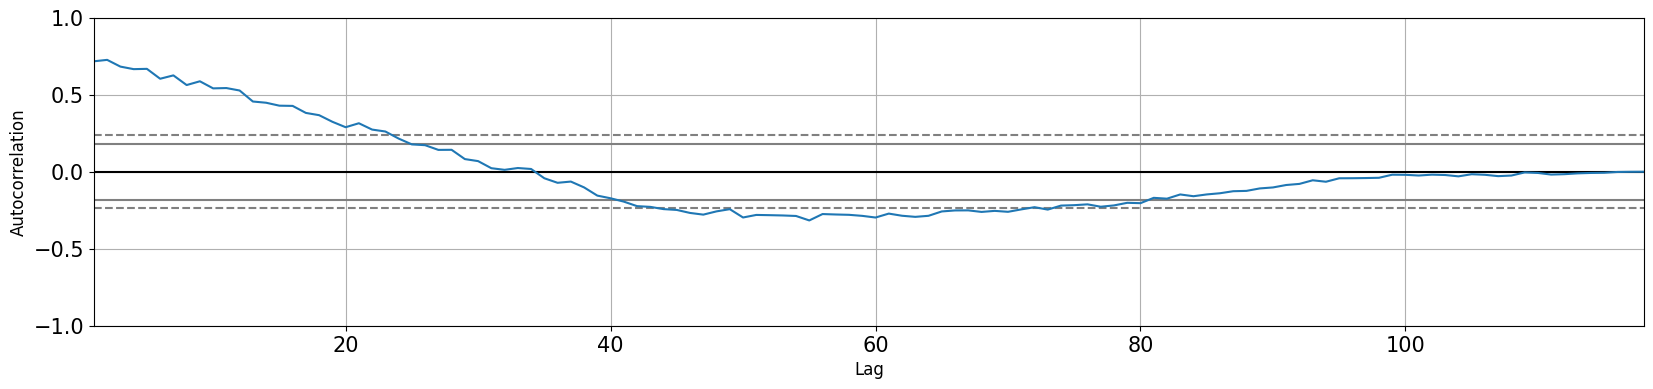

In [68]:
plt.figure(figsize=(20,4))
pd.plotting.autocorrelation_plot(df);

In [69]:
first_diff=df.diff()[1:]
# first_diff

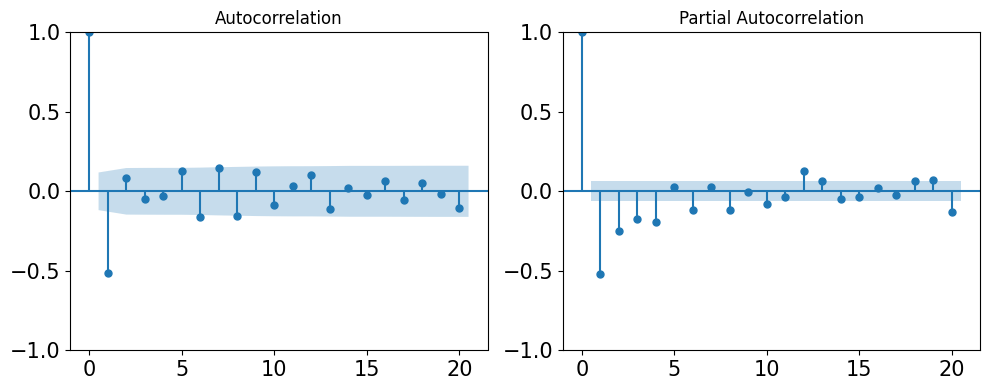

In [70]:
import statsmodels.tsa.api as smt
fig,axes=plt.subplots(1,2,sharex=False,sharey=False)
fig.set_figwidth(10)
fig.set_figheight(4)
smt.graphics.plot_acf(first_diff, lags=20, ax=axes[0], alpha=0.2) # Autocorelation
smt.graphics.plot_pacf(first_diff, lags=20, ax=axes[1], alpha=0.5) # Partial-Autocorelation
plt.tight_layout()

In [71]:
train.shape

(77, 1)

In [72]:
train_len=len(train)
train_len

naive=test.copy()
naive['naive_forecast']=train['sold_items'][train_len-1]
# naive

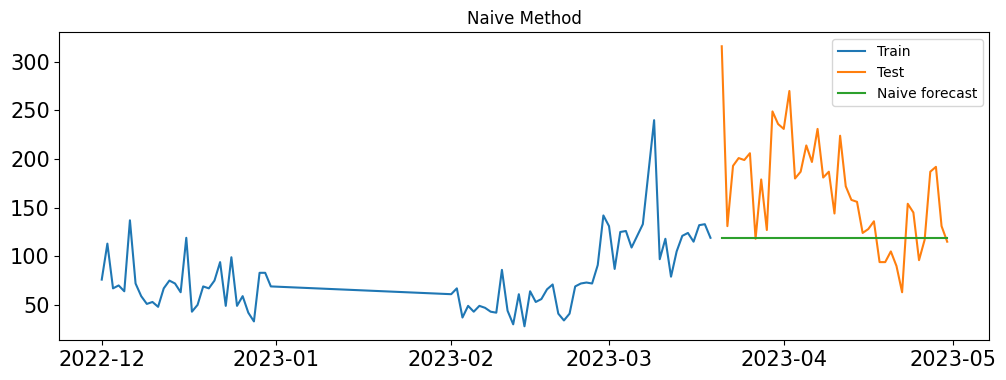

In [73]:
plt.figure(figsize=(12,4))
plt.plot(train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(naive['naive_forecast'], label='Naive forecast')
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.legend()
plt.title('Naive Method');

In [74]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test['sold_items'], naive['naive_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-naive['naive_forecast'])/test['sold_items'])*100,2)

results = pd.DataFrame({'Method':['Naive method'], 'MAPE': [mape], 'RMSE': [rmse]})
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,72.4,30.76


SES-error ga ada prediksi

In [75]:
warnings.filterwarnings('ignore')
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
model = SimpleExpSmoothing(train['sold_items'])
model_fit = model.fit(optimized=True)
model_fit.params
simp_expo= test.copy()
simp_expo['simp_expo_forecast'] = model_fit.forecast(len(test))

In [76]:
model_fit.params

{'smoothing_level': 0.2740113243842169,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 81.89682546143382,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

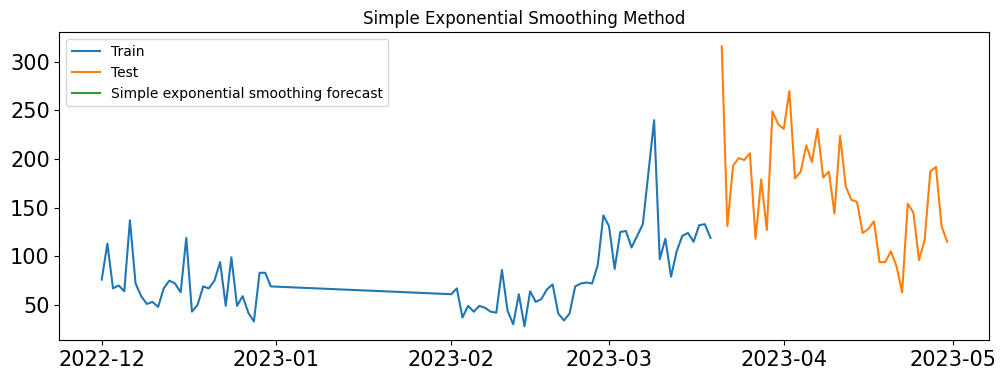

In [77]:
plt.figure(figsize=(12,4))
plt.plot(train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(simp_expo['simp_expo_forecast'], label='Simple exponential smoothing forecast')
plt.legend()
plt.title('Simple Exponential Smoothing Method');

holt's method

In [78]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(np.asarray(train['sold_items']) ,seasonal_periods=12 ,trend='additive', seasonal=None)
model_fit = model.fit(optimized=True)
print(model_fit.params)
holt_trend = test.copy()
holt_trend['holt_trend_forecast'] = model_fit.forecast(len(test))


{'smoothing_level': 0.2633926529895339, 'smoothing_trend': 0.0, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 79.37900820553917, 'initial_trend': 0.5862273503257088, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


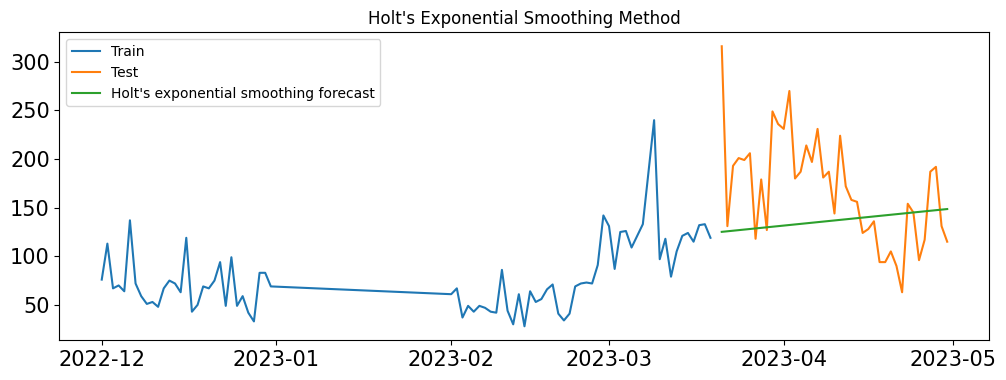

In [79]:
plt.figure(figsize=(12,4))
plt.plot( train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(holt_trend['holt_trend_forecast'], label='Holt\'s exponential smoothing forecast')
plt.legend()
plt.title('Holt\'s Exponential Smoothing Method');

In [80]:
rmse = np.sqrt(mean_squared_error(test['sold_items'], holt_trend['holt_trend_forecast'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-holt_trend['holt_trend_forecast'])/test['sold_items'])*100,2)

tempResults = pd.DataFrame({'Method':['Holt\'s exponential smoothing method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Naive method,72.40,30.76
0,Holt's exponential smoothing method,65.71,30.74


In [81]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [82]:
import pmdarima as pm

def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries,
                             start_p=1,
                             start_q=1,
                             test='adf',
                             seasonal=True,
                             trace=True,
                             stepwise=False)
    return automodel

In [83]:
from statsmodels.tsa.arima.model import ARIMA
automodel=ARIMA(test,order=(0,1,1))
automodel=automodel.fit()
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             sold_items   No. Observations:                   41
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -210.157
Date:                Fri, 23 Jun 2023   AIC                            424.313
Time:                        14:34:31   BIC                            427.691
Sample:                    03-21-2023   HQIC                           425.534
                         - 04-30-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6717      0.144     -4.680      0.000      -0.953      -0.390
sigma2      2113.9478    452.904      4.668      0.000    1226.273    3001.623
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):                 3.24
Prob(Q):                              0.53   Prob(JB):                         0.20
Heteroskedasticity (H):               0.42   Skew:                            -0.25
Prob(H) (two-sided):                  0.13   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
prediction_arima = automodel.predict(n_periodes=test.shape[0])
# prediction_arima

In [85]:
prediction_arima['prediction_arima'] = automodel.predict(n_periodes=test.shape[0])
# prediction_arima['prediction_arima']

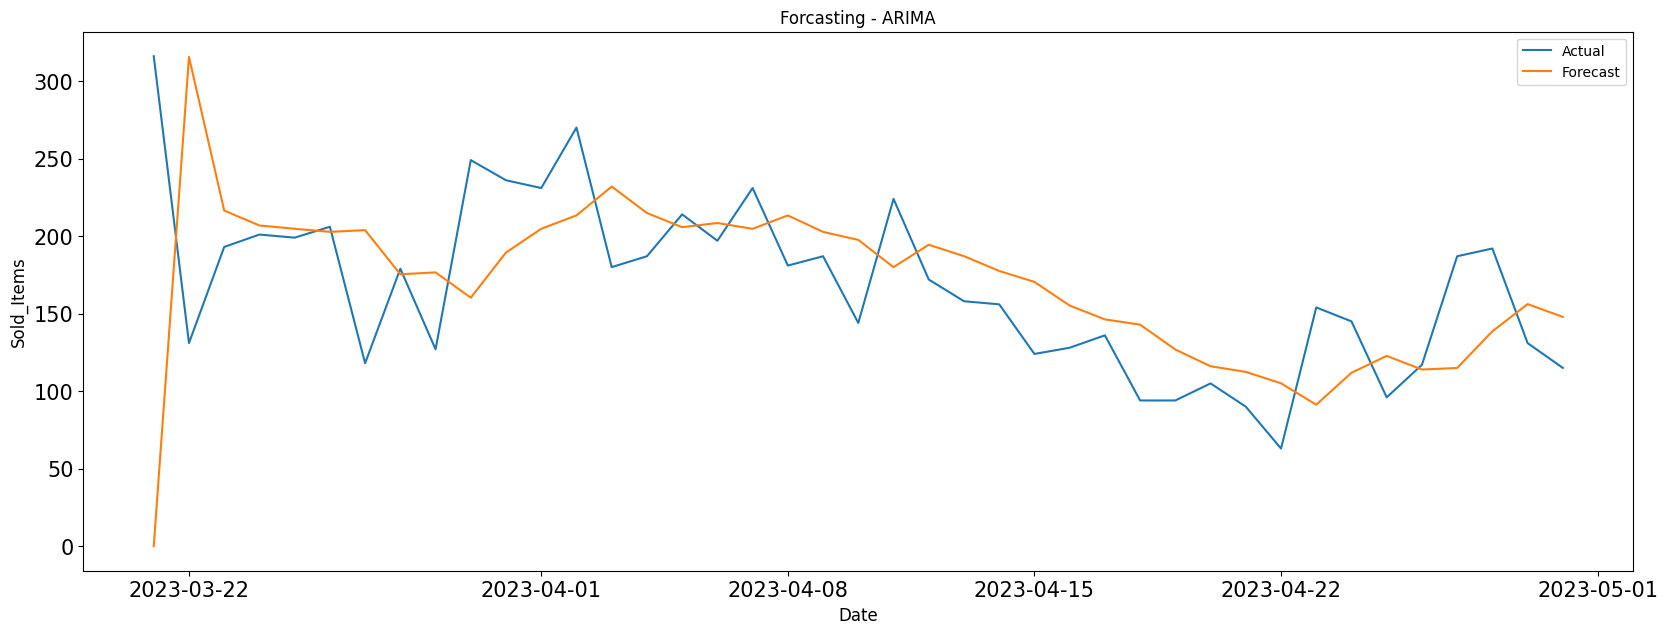

In [86]:
plt.figure(figsize=(20,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, prediction_arima['prediction_arima'], label='Forecast')
plt.title('Forcasting - ARIMA')
plt.xlabel('Date')
plt.ylabel('Sold_Items')
plt.legend()
plt.show()

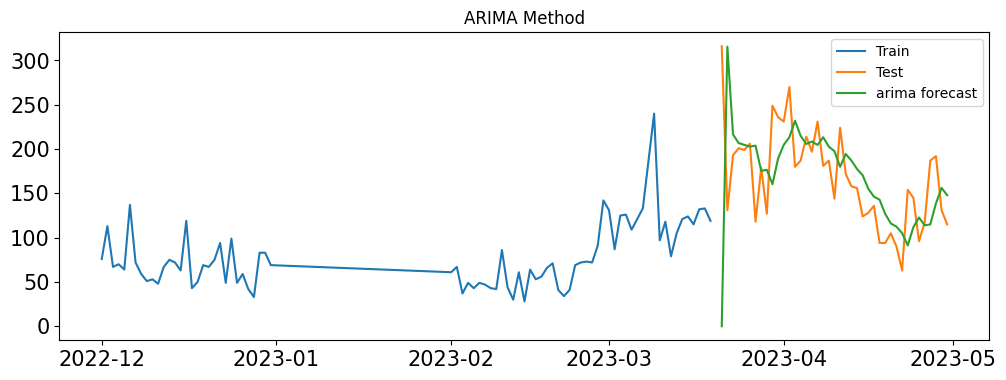

In [87]:
plt.figure(figsize=(12,4))
plt.plot( train['sold_items'], label='Train')
plt.plot(test['sold_items'], label='Test')
plt.plot(prediction_arima['prediction_arima'], label='arima forecast')
plt.legend()
plt.title('ARIMA Method');

In [88]:
rmse = np.sqrt(mean_squared_error(test['sold_items'], prediction_arima['prediction_arima'])).round(2)
mape = np.round(np.mean(np.abs(test['sold_items']-prediction_arima['prediction_arima'])/test['sold_items'])*100,2)

tempResults = pd.DataFrame({'Method':['ARIMA Method'], 'RMSE': [rmse],'MAPE': [mape] })
results = pd.concat([results, tempResults])
results = results[['Method', 'RMSE', 'MAPE']]
results


,Method,RMSE,MAPE
0,Naive method,72.40,30.76
0,Holt's exponential smoothing method,65.71,30.74
0,ARIMA Method,68.96,27.29


In [101]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'dataset' with a column named 'Value'

# Train the ARIMA model on the original dataset
model = sm.tsa.ARIMA(df['sold_items'], order=(0, 1, 1))  # Replace p, d, q with appropriate values
model_fit = model.fit()

# Create a new dataset with the desired date range for forecasting
date_series = pd.date_range(start='2023-05-01', periods=30, freq='D')  # Adjust start date and number of periods as needed
new_data = pd.DataFrame(index=date_series, columns=['sold_items'])

# Forecast values for the new dataset
forecast = model_fit.forecast(steps=len(new_data))
# forecast = model_fit.forecast(n_periodes=new_data.shape[0])
new_data['sold_items'] = forecast

# Concatenate the new data with the original dataset
updated_dataset = pd.concat([df, new_data])

# Display the updated dataset
print(updated_dataset)


                     sold_items
2022-12-01                 76.0
2022-12-02                113.0
2022-12-03                 67.0
2022-12-04                 70.0
2022-12-05                 64.0
...                         ...
2023-05-26 00:00:00         NaN
2023-05-27 00:00:00         NaN
2023-05-28 00:00:00         NaN
2023-05-29 00:00:00         NaN
2023-05-30 00:00:00         NaN

[148 rows x 1 columns]


In [106]:
from statsmodels.tsa.arima.model import ARIMA
automodel=ARIMA(updated_dataset,order=(0,1,1))
automodel=automodel.fit()
automodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             sold_items   No. Observations:                  148
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -588.203
Date:                Fri, 23 Jun 2023   AIC                           1180.405
Time:                        15:14:11   BIC                           1186.386
Sample:                             0   HQIC                          1182.836
                                - 148                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6836      0.059    -11.566      0.000      -0.799      -0.568
sigma2      1354.8824     89.684     15.107      0.000    1179.104    1530.661
===================================================================================
Ljung-Box (L1) (Q):                   0.35   Jarque-Bera (JB):               450.90
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             1.75
Prob(H) (two-sided):                  0.84   Kurtosis:                        10.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
prediction_arima = automodel.predict(n_periodes=updated_dataset.shape[0])
prediction_arima['prediction_arima'] = automodel.predict(n_periodes=updated_dataset.shape[0])
prediction_arima['prediction_arima']

2022-12-01               0.000000
2022-12-02              75.929749
2022-12-03              95.722020
2022-12-04              84.092809
2022-12-05              79.084324
                          ...    
2023-05-26 00:00:00    137.114182
2023-05-27 00:00:00    137.114182
2023-05-28 00:00:00    137.114182
2023-05-29 00:00:00    137.114182
2023-05-30 00:00:00    137.114182
Name: predicted_mean, Length: 148, dtype: float64

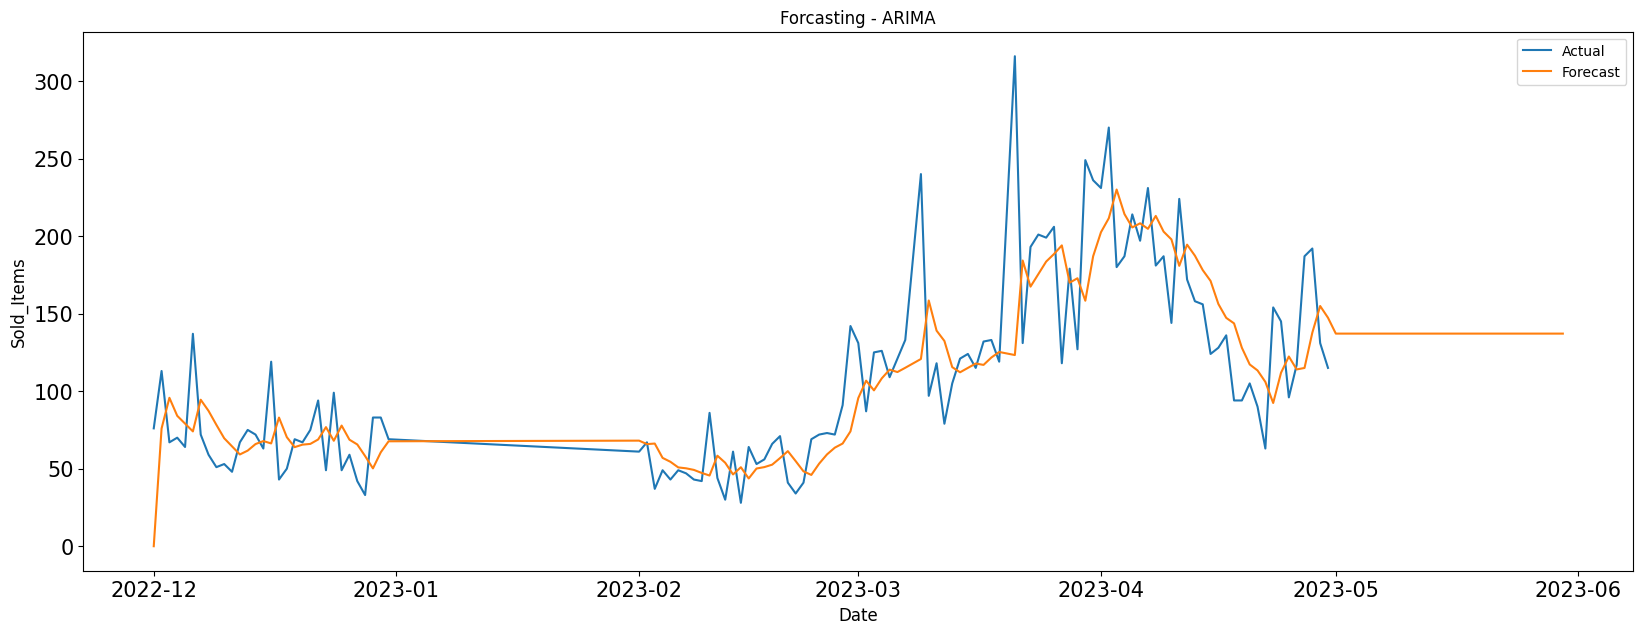

In [108]:
plt.figure(figsize=(20,7))
plt.plot(df.index, df, label='Actual')
plt.plot(updated_dataset.index, prediction_arima['prediction_arima'], label='Forecast')
plt.title('Forcasting - ARIMA')
plt.xlabel('Date')
plt.ylabel('Sold_Items')
plt.legend()
plt.show()

In [109]:
import pandas as pd

# Assuming you have a DataFrame named 'prediction_arima' with 'prediction_arima' column
n_periodes = updated_dataset.shape[0]  # Number of periods in the updated dataset

# Predict values for the new dataset
predictions = automodel.predict(n_periodes=n_periodes)

# Create a new DataFrame with the predictions
prediction_table = pd.DataFrame()
prediction_table['Prediction'] = predictions

# Display the prediction table
print(prediction_table)


                     Prediction
2022-12-01             0.000000
2022-12-02            75.929749
2022-12-03            95.722020
2022-12-04            84.092809
2022-12-05            79.084324
...                         ...
2023-05-26 00:00:00  137.114182
2023-05-27 00:00:00  137.114182
2023-05-28 00:00:00  137.114182
2023-05-29 00:00:00  137.114182
2023-05-30 00:00:00  137.114182

[148 rows x 1 columns]


In [110]:
import pandas as pd

# Assuming you have a DataFrame named 'prediction_table' with the predictions

# Specify the file path for the Excel file
file_path = 'prediction_results.xlsx'  # Replace with your desired file path

# Save the prediction table as an Excel file
prediction_table.to_excel(file_path, index=False)

print("Prediction results saved to Excel file.")


Prediction results saved to Excel file.


In [ ]:
import pandas as pd
import statsmodels.api as sm

# Assuming you have a DataFrame named 'dataset' with a column named 'Value'

# Train the ARIMA model on the original dataset
model = sm.tsa.ARIMA(dataset['Value'], order=(p, d, q))  # Replace p, d, q with appropriate values
model_fit = model.fit()

# Create a new dataset with the desired date range for forecasting
date_series = pd.date_range(start='2023-07-01', periods=30, freq='D')  # Adjust start date and number of periods as needed
new_data = pd.DataFrame(index=date_series, columns=['Value'])

# Forecast values for the new dataset
forecast = model_fit.forecast(steps=len(new_data))
new_data['Value'] = forecast[0]  # Use forecast[0] to access the forecasted values

# Concatenate the new data with the original dataset
updated_dataset = pd.concat([dataset, new_data])

# Display the updated dataset
print(updated_dataset)


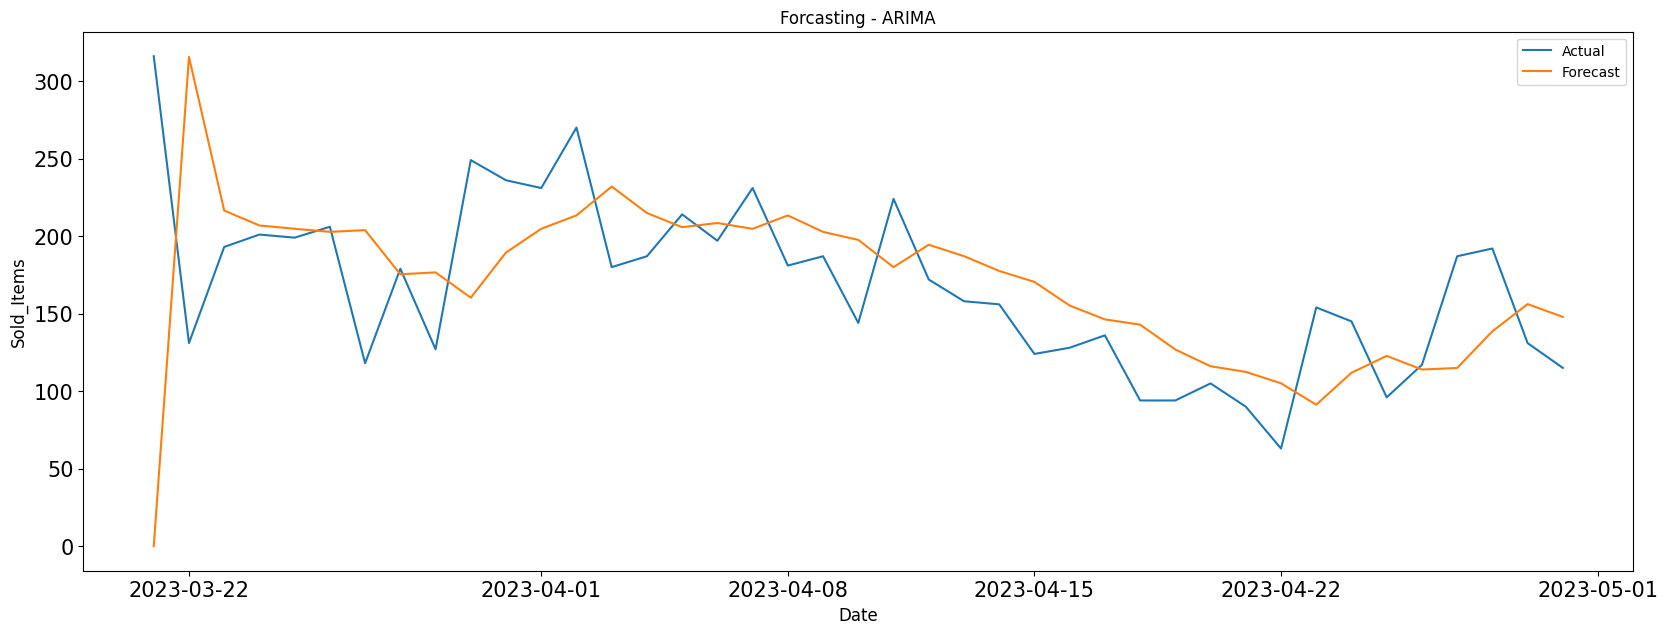

In [91]:
plt.figure(figsize=(20,7))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, prediction_arima['prediction_arima'], label='Forecast')
plt.title('Forcasting - ARIMA')
plt.xlabel('Date')
plt.ylabel('Sold_Items')
plt.legend()
plt.show()